# Skip-gram Word2Vec

In this notebook, I'll lead you through using PyTorch to implement the [Word2Vec algorithm](https://en.wikipedia.org/wiki/Word2vec) using the skip-gram architecture. By implementing this, you'll learn about embedding words for use in natural language processing. This will come in handy when dealing with things like machine translation.

---
## Loading Data

Next, we'll ask you to load in data and place it in the `data` directory. we'll be leveraging 100 MB of cleaned text from Wikipedia

1. Load the [text8 dataset](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/October/5bbe6499_text8/text8.zip); a file of cleaned up *Wikipedia article text* from Matt Mahoney. 
2. Place that data in the `data` folder in the home directory.
3. Then you can extract it and delete the archive, zip file to save storage space.

After following these steps, you should have one file in your data directory: `data/text8`.

(Sorry that i didn't automate this for you, I know I could have)

In [1]:
# read in the extracted text file      
with open('data/text8') as f:
    text = f.read()

# print out the first 100 characters
print(text[:100])

 anarchism originated as a term of abuse first used against early working class radicals including t


## Pre-processing

Here I'm fixing up the text to make training easier. This comes from the `utils.py` file. The `preprocess` function does a few things:
>* It converts any punctuation into tokens, so a period is changed to ` <PERIOD> `. In this data set, there aren't any periods, but it will help in other NLP problems. 
* It removes all words that show up five or *fewer* times in the dataset. This will greatly reduce issues due to noise in the data and improve the quality of the vector representations. 
* It returns a list of words in the text.

This may take a few seconds to run, since our text file is quite large. If you want to write your own functions for this stuff, go for it!

In [2]:
import utils

# get list of words
words = utils.preprocess(text)
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [3]:
# print some stats about this word data
print("Total words in text: {}".format(len(words)))
print("Unique words: {}".format(len(set(words)))) # `set` removes any duplicate words

Total words in text: 16680599
Unique words: 63641


### Dictionaries

Next, I'm creating two dictionaries to convert words to integers and back again (integers to words). This is again done with a function in the `utils.py` file. `create_lookup_tables` takes in a list of words in a text and returns two dictionaries.
>* The integers are assigned in descending frequency order, so the most frequent word ("the") is given the integer 0 and the next most frequent is 1, and so on. 

Once we have our dictionaries, the words are converted to integers and stored in the list `int_words`.

In [4]:
from collections import Counter
import random
import numpy as np

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_en = set(stopwords.words('english'))
train_words = [wd for wd in words if wd not in stop_en]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\10838233\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
import matplotlib.pyplot as plt
ctr = Counter(train_words)

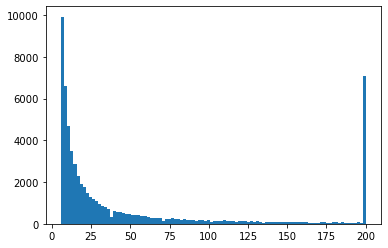

In [6]:
plt.hist([min(c, 200) for c in ctr.values()], bins=100)
plt.show()

In [7]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(train_words)
int_words = [vocab_to_int[word] for word in train_words]

if 0:
    # This filtering appears already done for us with min = 6
    word_counts = Counter(int_words)

    total_count = len(int_words)
    counts_raw = {word: count for word, count in word_counts.items()}
    int_words = [word for word in int_words if counts_raw[word] > 5]

word_counts = Counter(int_words)
total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}

len(int_words), len(train_words), len(int_words)/len(train_words)


(10566033, 10566033, 1.0)

In [8]:
idx_to_id = {idx:id for idx, id in enumerate(int_words)}
train_length = len(int_words)
n_window = 3
n_vocab = len(vocab_to_int)

In [9]:
import torch
from torch import nn
import torch.optim as optim

class SkipGram(nn.Module):
    def __init__(self, n_vocab, n_embed):
        super().__init__()
        
        self.center_emb = nn.Embedding(n_vocab, n_embed)
        self.outer_emb = nn.Embedding(n_vocab, n_embed)
#         self.log_softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x_center, x_outer, target):
        xc = self.center_emb(x_center)
        xo = self.outer_emb(x_outer)
        scores = torch.sum(xc * xo, axis=1)
        probs = torch.sigmoid(scores)
        
        return scores, probs

In [10]:
n_neg = 8

In [11]:
word_counts = Counter(int_words)
total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}

In [12]:
wd_with_p = [wd for wd in freqs.keys()]
p_per_wd = [freqs[wd] ** (3/4) for wd in wd_with_p]
p_sum = sum(p_per_wd)
p_per_wd = [p/p_sum for p in p_per_wd]

In [13]:
pos_bs = 32
xi_center = np.random.choice(train_length - n_window * 2, pos_bs, replace=False) + n_window
xi_outer = (np.random.choice(n_window, pos_bs)+1) * np.random.choice([-1, 1], pos_bs) + xi_center

In [14]:
%timeit np.take(int_words, xi_center)

722 ms ± 90.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


How much faster would it be if we vecttorized it with a dictionary instead?

In [15]:
id_getter = np.vectorize(idx_to_id.get)

In [16]:
%timeit id_getter(xi_center)

13.6 µs ± 753 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [17]:
xpos_center = id_getter(xi_center)
xpos_outer = id_getter(xi_outer)

xneg_center = np.random.choice(wd_with_p, size = pos_bs * n_neg, replace=False, p = p_per_wd)
xneg_outer = np.random.choice(wd_with_p, size = pos_bs * n_neg, replace=False, p = p_per_wd)

In [20]:
len(wd_with_p)

63491

In [21]:
n_vocab

63491

In [23]:
xneg_outer.max()

62040

In [24]:
model.center_emb

Embedding(63491, 300)

In [36]:
# check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

embedding_dim= 50 # you can change, if you want

model = SkipGram(len(vocab_to_int), embedding_dim).to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

print_every = 100
steps = 0
epochs = 5

# train for some number of epochs
# for e in range(epochs):
    
    # get input and target batches
#     for inputs, targets in get_batches(train_words, 512):
for step in range(epochs * train_length):
    xi_center = np.random.choice(train_length - n_window * 2, pos_bs, replace=False) + n_window
    xi_outer = (np.random.choice(n_window, pos_bs)+1) * np.random.choice([-1, 1], pos_bs) + xi_center
    xneg_center = np.random.choice(wd_with_p, size = pos_bs * n_neg, replace=False, p = p_per_wd)
    xneg_outer = np.random.choice(wd_with_p, size = pos_bs * n_neg, replace=False, p = p_per_wd)
    x_center = np.concatenate((id_getter(xi_center), xneg_center))
    x_outer = np.concatenate((id_getter(xi_outer), xneg_outer))
    targets = np.array([1] * len(xi_center) + [0] * len(xneg_center))
    steps += 1
    x_center_torch, x_outer_torch, targets_torch = [torch.LongTensor(x).to(device) for x in [x_center, x_outer, targets]]
    
    scores, log_ps = model(x_center_torch, x_outer_torch, targets_torch)
    loss = criterion(log_ps, targets_torch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if steps % print_every == 0:                  
        # getting examples and similarities      
        valid_examples, valid_similarities = cosine_similarity(model.embed, device=device)
        _, closest_idxs = valid_similarities.topk(6) # topk highest similarities

        valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')
        for ii, valid_idx in enumerate(valid_examples):
            closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
            print(int_to_vocab[valid_idx.item()] + " | " + ', '.join(closest_words))
        print("...")

NameError: name 'cosine_similarity' is not defined

## Subsampling

Words that show up often such as "the", "of", and "for" don't provide much context to the nearby words. If we discard some of them, we can remove some of the noise from our data and in return get faster training and better representations. This process is called subsampling by Mikolov. For each word $w_i$ in the training set, we'll discard it with probability given by 

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

where $t$ is a threshold parameter and $f(w_i)$ is the frequency of word $w_i$ in the total dataset.

$$ P(0) = 1 - \sqrt{\frac{1*10^{-5}}{1*10^6/16*10^6}} = 0.98735 $$

I'm going to leave this up to you as an exercise. Check out my solution to see how I did it.

> **Exercise:** Implement subsampling for the words in `int_words`. That is, go through `int_words` and discard each word given the probablility $P(w_i)$ shown above. Note that $P(w_i)$ is the probability that a word is discarded. Assign the subsampled data to `train_words`.

### JUST KIDDING! What the heck is that talking about, we don't need complex algorithms, just throw away our stop words!

In [ ]:
from collections import Counter
import random
import numpy as np

# threshold = 1e-5
# word_counts = Counter(int_words)
# #print(list(word_counts.items())[0])  # dictionary of int_words, how many times they appear

# total_count = len(int_words)
# freqs = {word: count/total_count for word, count in word_counts.items()}
# p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
# # discard some frequent words, according to the subsampling equation
# # create a new list of words for training
# train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

# print(train_words[:30])


In [ ]:
len(words), len(train_words), len(train_words)/len(words)

## Making batches

In [ ]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = words[start:idx] + words[idx+1:stop+1]
    
    return list(target_words)

In [ ]:
int_text = [i for i in range(10)]
print('Input: ', int_text)
idx=5 # word index of interest

target = get_target(int_text, idx=idx, window_size=5)
print('Target: ', target)  # you should get some indices around the idx

### Generating Batches 

Here's a generator function that returns batches of input and target data for our model, using the `get_target` function from above. The idea is that it grabs `batch_size` words from a words list. Then for each of those batches, it gets the target words in a window.

In [ ]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        # TODO: This is slow, can you do it without the inner for loop?
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y
    

In [ ]:
int_text = [i for i in range(1000)]
x,y = next(get_batches(int_text, batch_size=4, window_size=5))

print('x\n', x)
print('y\n', y)

## Building the graph

Below is an approximate diagram of the general structure of our network.
<img src="assets/skip_gram_arch.png" width=60%>

>* The input words are passed in as batches of input word tokens. 
* This will go into a hidden layer of linear units (our embedding layer). 
* Then, finally into a softmax output layer. 

We'll use the softmax layer to make a prediction about the context words by sampling, as usual.

The idea here is to train the embedding layer weight matrix to find efficient representations for our words. We can discard the softmax layer because we don't really care about making predictions with this network. We just want the embedding matrix so we can use it in _other_ networks we build using this dataset.

---
## Validation

Here, I'm creating a function that will help us observe our model as it learns. We're going to choose a few common words and few uncommon words. Then, we'll print out the closest words to them using the cosine similarity: 

<img src="assets/two_vectors.png" width=30%>

$$
\mathrm{similarity} = \cos(\theta) = \frac{\vec{a} \cdot \vec{b}}{|\vec{a}||\vec{b}|}
$$


We can encode the validation words as vectors $\vec{a}$ using the embedding table, then calculate the similarity with each word vector $\vec{b}$ in the embedding table. With the similarities, we can print out the validation words and words in our embedding table semantically similar to those words. It's a nice way to check that our embedding table is grouping together words with similar semantic meanings.

In [ ]:
def cosine_similarity(embedding, valid_size=16, valid_window=100, device='cpu'):
    """ Returns the cosine similarity of validation words with words in the embedding matrix.
        Here, embedding should be a PyTorch embedding module.
    """
    
    # Here we're calculating the cosine similarity between some random words and 
    # our embedding vectors. With the similarities, we can look at what words are
    # close to our random words.
    
    # sim = (a . b) / |a||b|
    
    embed_vectors = embedding.weight
    
    # magnitude of embedding vectors, |b|
    magnitudes = embed_vectors.pow(2).sum(dim=1).sqrt().unsqueeze(0)
    
    # pick N words from our ranges (0,window) and (1000,1000+window). lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples,
                               random.sample(range(1000,1000+valid_window), valid_size//2))
    valid_examples = torch.LongTensor(valid_examples).to(device)
    
    valid_vectors = embedding(valid_examples)
    similarities = torch.mm(valid_vectors, embed_vectors.t())/magnitudes
        
    return valid_examples, similarities

## SkipGram model

Define and train the SkipGram model. 
> You'll need to define an [embedding layer](https://pytorch.org/docs/stable/nn.html#embedding) and a final, softmax output layer.

An Embedding layer takes in a number of inputs, importantly:
* **num_embeddings** – the size of the dictionary of embeddings, or how many rows you'll want in the embedding weight matrix
* **embedding_dim** – the size of each embedding vector; the embedding dimension

In [ ]:
import torch
from torch import nn
import torch.optim as optim

class SkipGram(nn.Module):
    def __init__(self, n_vocab, n_embed):
        super().__init__()
        
        self.embed = nn.Embedding(n_vocab, n_embed)
        self.output = nn.Linear(n_embed, n_vocab)
        self.log_softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.embed(x)
        scores = self.output(x)
        log_ps = self.log_softmax(scores)
        
        return log_ps

### Training

Below is our training loop, and I recommend that you train on GPU, if available.

**Note that, because we applied a softmax function to our model output, we are using NLLLoss** as opposed to cross entropy. This is because Softmax  in combination with NLLLoss = CrossEntropy loss .

In [ ]:
# check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

embedding_dim=300 # you can change, if you want

model = SkipGram(len(vocab_to_int), embedding_dim).to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

print_every = 500
steps = 0
epochs = 5

# train for some number of epochs
for e in range(epochs):
    
    # get input and target batches
    for inputs, targets in get_batches(train_words, 512):
        steps += 1
        inputs, targets = torch.LongTensor(inputs), torch.LongTensor(targets)
        inputs, targets = inputs.to(device), targets.to(device)
        
        log_ps = model(inputs)
        loss = criterion(log_ps, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if steps % print_every == 0:                  
            # getting examples and similarities      
            valid_examples, valid_similarities = cosine_similarity(model.embed, device=device)
            _, closest_idxs = valid_similarities.topk(6) # topk highest similarities
            
            valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')
            for ii, valid_idx in enumerate(valid_examples):
                closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
                print(int_to_vocab[valid_idx.item()] + " | " + ', '.join(closest_words))
            print("...")

## Visualizing the word vectors

Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project these vectors into two dimensions while preserving local stucture. Check out [this post from Christopher Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) to learn more about T-SNE and other ways to visualize high-dimensional data.

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [ ]:
# getting embeddings from the embedding layer of our model, by name
embeddings = model.embed.weight.to('cpu').data.numpy()

In [ ]:
viz_words = 600
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

In [ ]:
fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)